In [1]:
import numpy as np
import qiskit as qk
import pickle as pk
import qutip as qt
import matplotlib.pyplot as plt
import copy
import random
import cmath
from datetime import datetime
from math import pi
from qiskit import Aer
from qiskit.quantum_info.operators import Operator
from math import cos, sin, pi, exp
from qiskit import QuantumCircuit, transpile, assemble

from qiskit.quantum_info.operators import Operator, Pauli
from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram
from qiskit import IBMQ
from qiskit_ibm_provider import IBMProvider
%matplotlib inline

ImportError: cannot import name 'Aer' from 'qiskit' (C:\Users\celia\anaconda3\Lib\site-packages\qiskit\__init__.py)

In [2]:
print("Qiskit version:", qk.__version__)


Qiskit version: 1.0.2


In [2]:
#IBMProvider.save_account(token = '2fb6c1b6d0ac4c51aafcdac37aa9596a919a9736ee1d21fe6180c3adde63b073bd687a3335f94a041acd8b049717c8f63a84a57fafaaeaad23edec56df9507d6')

provider = IBMProvider()



In [3]:
backend = provider.get_backend('ibm_osaka')


# Creating Dictionary for Hidden Inverse Experiment


In [90]:
#K = 16 # number of states
M = 15 # max number of repetitions

experiment_names = ['free_1','free_2', 'Swap_No_HI', 'Swap_HI','xy4_1','xy4_2']
experiments = []
for m in range(M):
    circuit_dict = {}
    circuit_dict['reps'] = m
    #for k in range(K):
        #circuit_dict['state'] = k
    for exp in experiment_names:
        circuit_dict['exp'] = exp
        experiments.append(copy.deepcopy(circuit_dict))

experiments

[{'reps': 0, 'exp': 'free_1'},
 {'reps': 0, 'exp': 'free_2'},
 {'reps': 0, 'exp': 'Swap_No_HI'},
 {'reps': 0, 'exp': 'Swap_HI'},
 {'reps': 0, 'exp': 'xy4_1'},
 {'reps': 0, 'exp': 'xy4_2'},
 {'reps': 1, 'exp': 'free_1'},
 {'reps': 1, 'exp': 'free_2'},
 {'reps': 1, 'exp': 'Swap_No_HI'},
 {'reps': 1, 'exp': 'Swap_HI'},
 {'reps': 1, 'exp': 'xy4_1'},
 {'reps': 1, 'exp': 'xy4_2'},
 {'reps': 2, 'exp': 'free_1'},
 {'reps': 2, 'exp': 'free_2'},
 {'reps': 2, 'exp': 'Swap_No_HI'},
 {'reps': 2, 'exp': 'Swap_HI'},
 {'reps': 2, 'exp': 'xy4_1'},
 {'reps': 2, 'exp': 'xy4_2'},
 {'reps': 3, 'exp': 'free_1'},
 {'reps': 3, 'exp': 'free_2'},
 {'reps': 3, 'exp': 'Swap_No_HI'},
 {'reps': 3, 'exp': 'Swap_HI'},
 {'reps': 3, 'exp': 'xy4_1'},
 {'reps': 3, 'exp': 'xy4_2'},
 {'reps': 4, 'exp': 'free_1'},
 {'reps': 4, 'exp': 'free_2'},
 {'reps': 4, 'exp': 'Swap_No_HI'},
 {'reps': 4, 'exp': 'Swap_HI'},
 {'reps': 4, 'exp': 'xy4_1'},
 {'reps': 4, 'exp': 'xy4_2'},
 {'reps': 5, 'exp': 'free_1'},
 {'reps': 5, 'exp': 'fre

# Creating the Swap Schedule from Backend

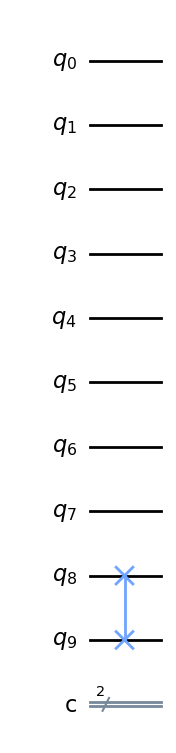

In [5]:
swap_circ = QuantumCircuit(10,2)

swap_circ.swap(9,8)

swap_circ.draw("mpl")

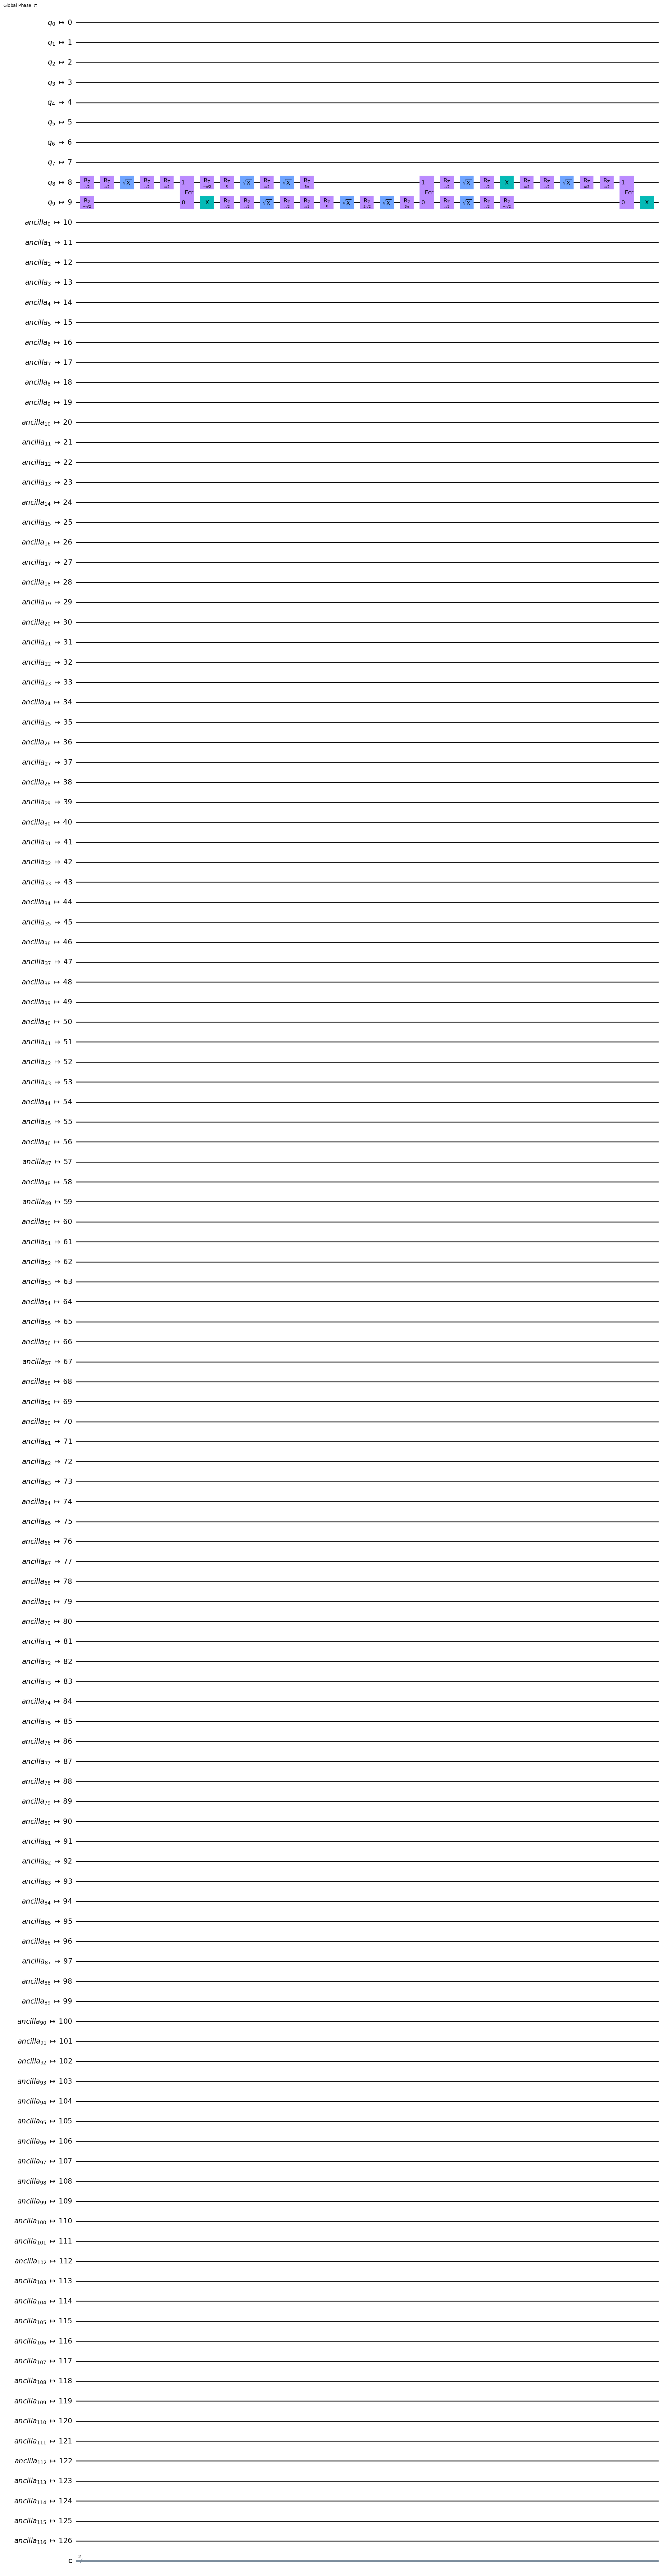

In [6]:
from qiskit import transpile, schedule as build_schedule

transpiled_swap_circ = transpile(swap_circ, backend=backend, optimization_level = 0)

transpiled_swap_circ.draw("mpl", fold = -1)

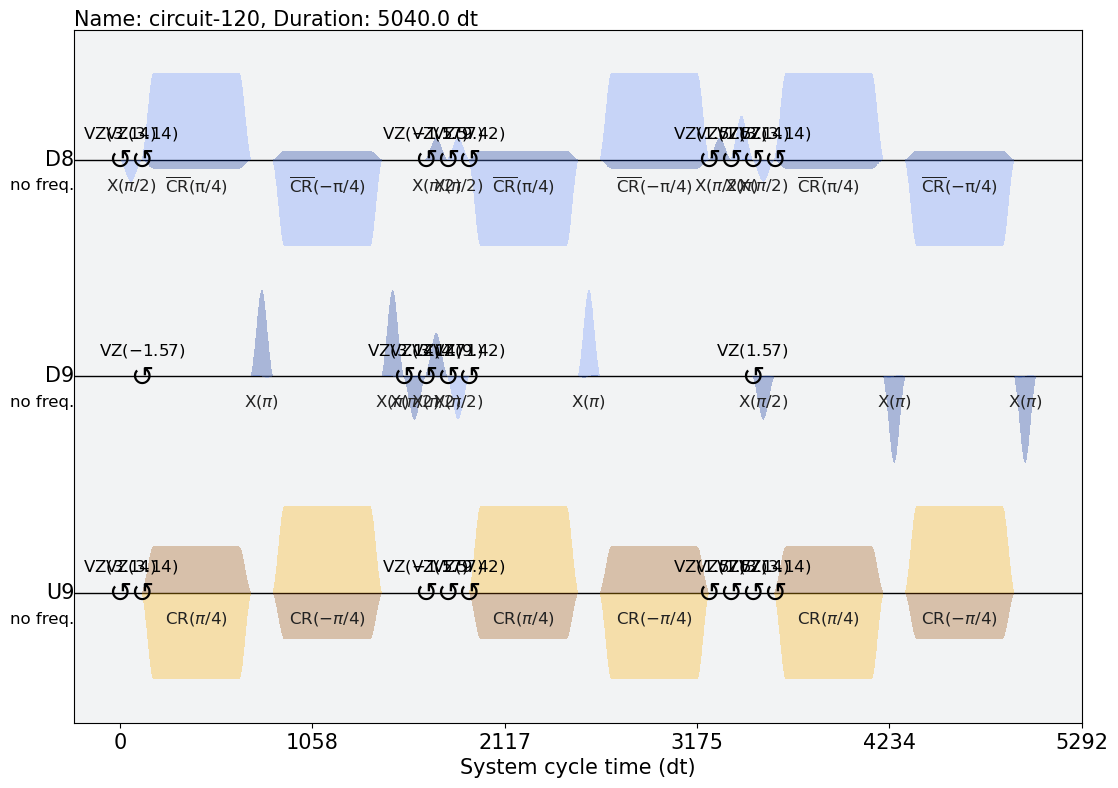

In [21]:
swap_schedule = build_schedule(transpiled_swap_circ, backend = backend)

swap_schedule.draw()

# Mirror Function to Obtain HI Pulse Schedule

In [8]:
from qiskit.pulse import Schedule, DriveChannel, Play, ShiftPhase, GaussianSquare, Gaussian, Drag


def approximate_pulse_schedule_inverse(original_schedule):
    inverse_pulse_schedule = Schedule()  # Only contains the pulse schedule of the inverse

    dur = original_schedule.duration

    for inst in reversed(original_schedule.instructions):
        instruction = inst[1]

        if isinstance(inst, tuple) and isinstance(inst[1], qk.pulse.instructions.phase.ShiftPhase):
            instruction = ShiftPhase(-inst[1].phase, inst[1].channel)
        elif isinstance(inst, tuple) and isinstance(inst[1], Play):
            if isinstance(inst[1].pulse, GaussianSquare):
                instruction = Play(GaussianSquare(duration=inst[1].pulse.duration, width=inst[1].pulse.width, amp=(-1) * inst[1].pulse.amp, sigma=inst[1].pulse.sigma, angle=inst[1].pulse.angle, name=inst[1].pulse.name), inst[1].channel, inst[1].name)
            elif isinstance(inst[1].pulse, Drag):
                instruction = Play(Drag(duration=inst[1].pulse.duration, beta=inst[1].pulse.beta, amp=(-1) * inst[1].pulse.amp, sigma=inst[1].pulse.sigma, angle=inst[1].pulse.angle, name=inst[1].pulse.name), inst[1].channel, inst[1].name)

        #inverse_pulse_schedule |= instruction.shift(dur * 2 - inst[1].duration - inst[0])
        inverse_pulse_schedule |= instruction.shift(dur - inst[1].duration - inst[0])


    return inverse_pulse_schedule

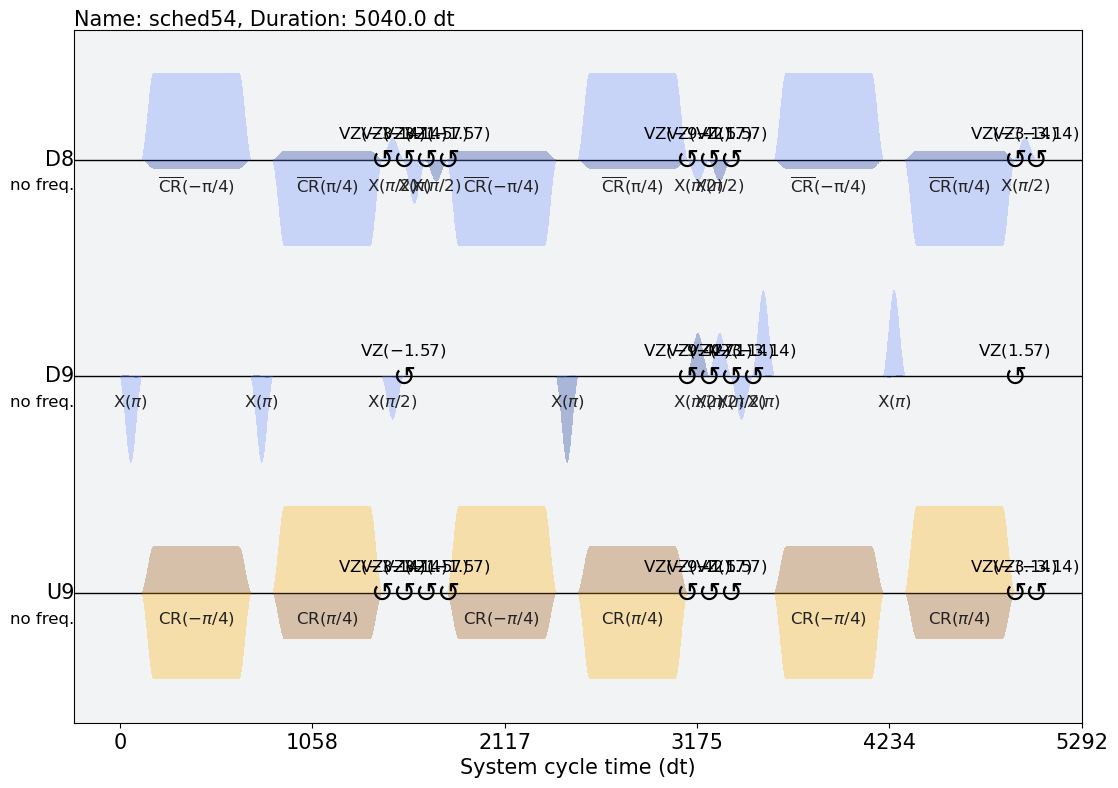

In [10]:
inverse_swap_schedule = approximate_pulse_schedule_inverse(swap_schedule)

inverse_swap_schedule.draw()

# Functions to create circuits


In [86]:
def ramsey_2(num_delays):
    circ = qk.QuantumCircuit(10,2)
    
    #initialization
    '''
    circ.x(9)
    circ.x(8)
    circ.h(9)
    circ.cx(9,8)
    '''
    
    
    for _ in range(num_delays):
        circ.delay(2520, 8, unit = 'ns')
        circ.delay(2520, 8, unit = 'ns') 
        circ.delay(2520, 9, unit = 'ns')
        circ.delay(2520, 9, unit = 'ns')

    
    #uninitialization
    '''
    circ.cx(9,8)
    circ.h(9)
    circ.barrier(9,8)
    circ.x(9)
    circ.x(8)
        
    circ.measure(9,0)
    circ.measure(8,1)
    '''
    return circ


In [92]:
def ramsey_1(num_delays, state):
    circ = qk.QuantumCircuit(10,1)
    #initialization
    
    theta, phi, lamb = state
    circ.u(theta, phi, lamb, 1)
    
    for _ in range(num_delays):
        circ.delay(2520, 8, unit = 'ns')
        circ.delay(2520, 8, unit = 'ns') 
    
    
    #uninitialization
    circ.u(-theta, -lamb, -phi, 1)
    circ.measure(9,0)
    return circ
    

In [ ]:
def xy4_1(num_reps):
    return circ

In [104]:
def xy4_2(num_reps):
    circ = qk.QuantumCircuit(10,2)
    
    #initialization
    '''
    circ.x(9)
    circ.x(8)
    circ.h(9)
    circ.cx(9,8)
    '''
    for _ in range(num_reps):
        for _ in range(42):
            circ.x(9) 
            circ.rz(pi/2, 9)
            circ.x(9)
            circ.rz(-pi/2,9)
        
            circ.x(8) 
            circ.rz(pi/2, 8)
            circ.x(8)
            circ.rz(-pi/2,8)
        
        
 
    
    #uninitialization
    '''
    circ.cx(9,8)
    circ.h(9)
    circ.barrier(9,8)
    circ.x(9)
    circ.x(8)
            
    circ.measure(9,0)
    circ.measure(8,1)
    '''
    return circ

In [65]:
def swap_No_HI(num_reps):
    circ = qk.QuantumCircuit(10,2)
    
    #initialization
    #circ.x(9)
    #circ.x(8)
    #circ.h(9)
    #circ.cx(9,8)

    
    for _ in range(num_reps):
        #circ.swap(9,8) 
        #circ.swap(9,8)
        circ.swap(9,8) 
        circ.swap(9,8)
        circ.barrier(9,8)
        circ.delay(60, 8, unit = 'ns')
        circ.delay(60, 9, unit = 'ns') 
        
        
        
    #uninitialization
    #circ.cx(9,8)
    #circ.h(9)
    #circ.barrier(9,8)
    #circ.x(9)
    #circ.x(8)
            
    #circ.measure(9,0)
    #circ.measure(8,1)
    return circ

In [36]:
def swap_HI(num_reps):
    circ = qk.QuantumCircuit(10,2)
    
    #initialization
    #circ.x(9)
    #circ.x(8)
    #circ.h(9)
    #circ.cx(9,8)
    
    swap_circ = QuantumCircuit(2, name='normal_swap')

    swap_circ.swap(1, 0)

    custom_gate = swap_circ.to_instruction()

    for _ in range(num_reps):
        
        #circ.append(custom_gate,[9,8])
        
        #circ.swap(9,8)
        
        circ.append(custom_gate,[9,8])
        
        circ.swap(9,8)
        
     
        

    #circ.add_calibration("swap", [9,8], inverse_schedule)
        
    circ.add_calibration("normal_swap", [9,8], swap_schedule)
        
        
        
    #uninitialization
    #circ.cx(9,8)
    #circ.h(9)
    #circ.barrier(9,8)
    #circ.x(9)
    #circ.x(8)
    
    
    
    #circ.measure(9,0)
    #circ.measure(8,1)
    return circ

# Verifying circuits

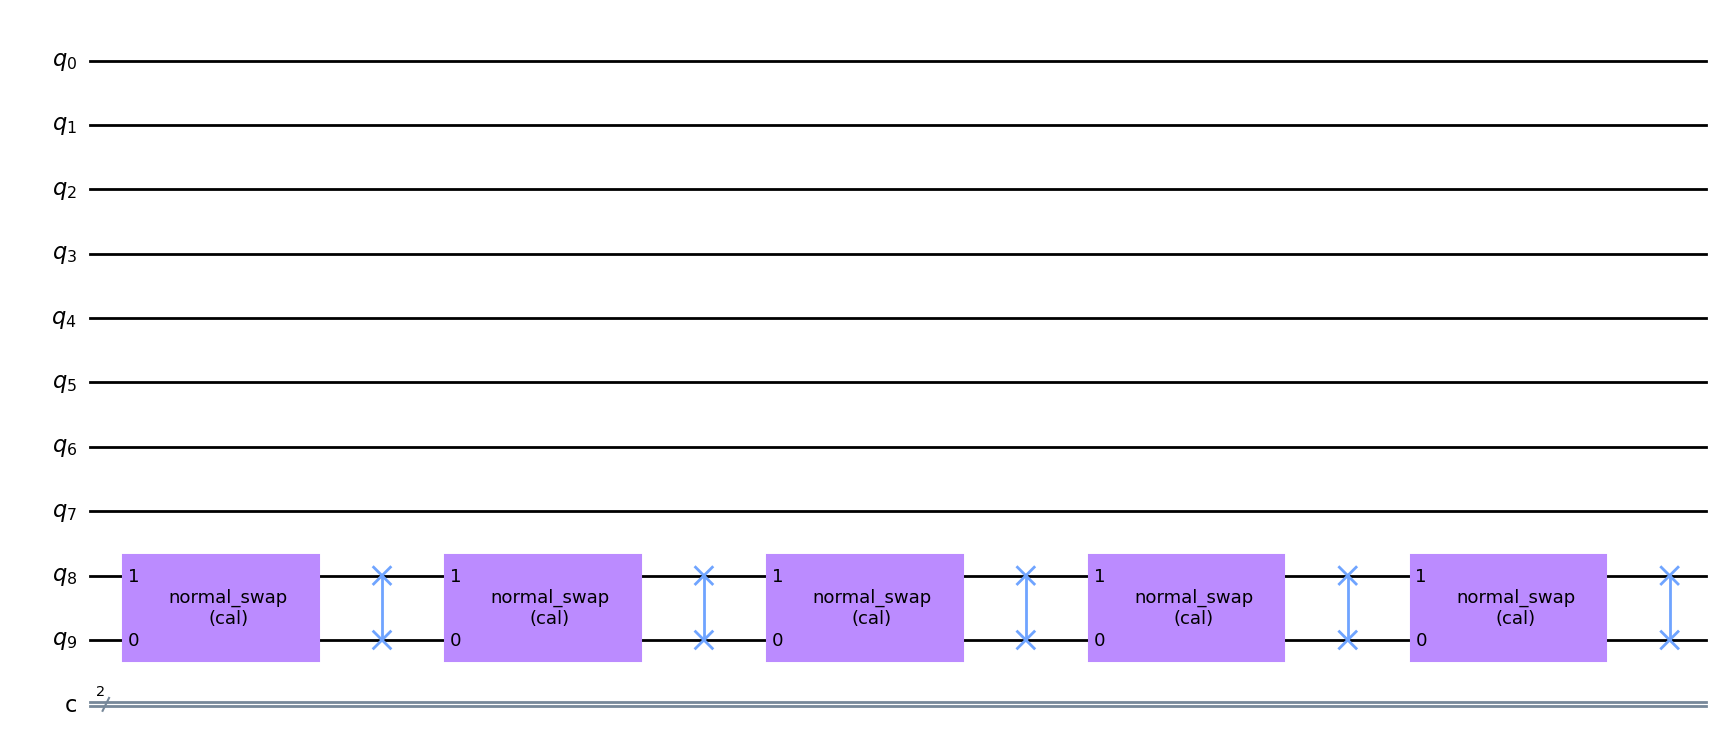

In [63]:
swap_HI(5).draw('mpl')

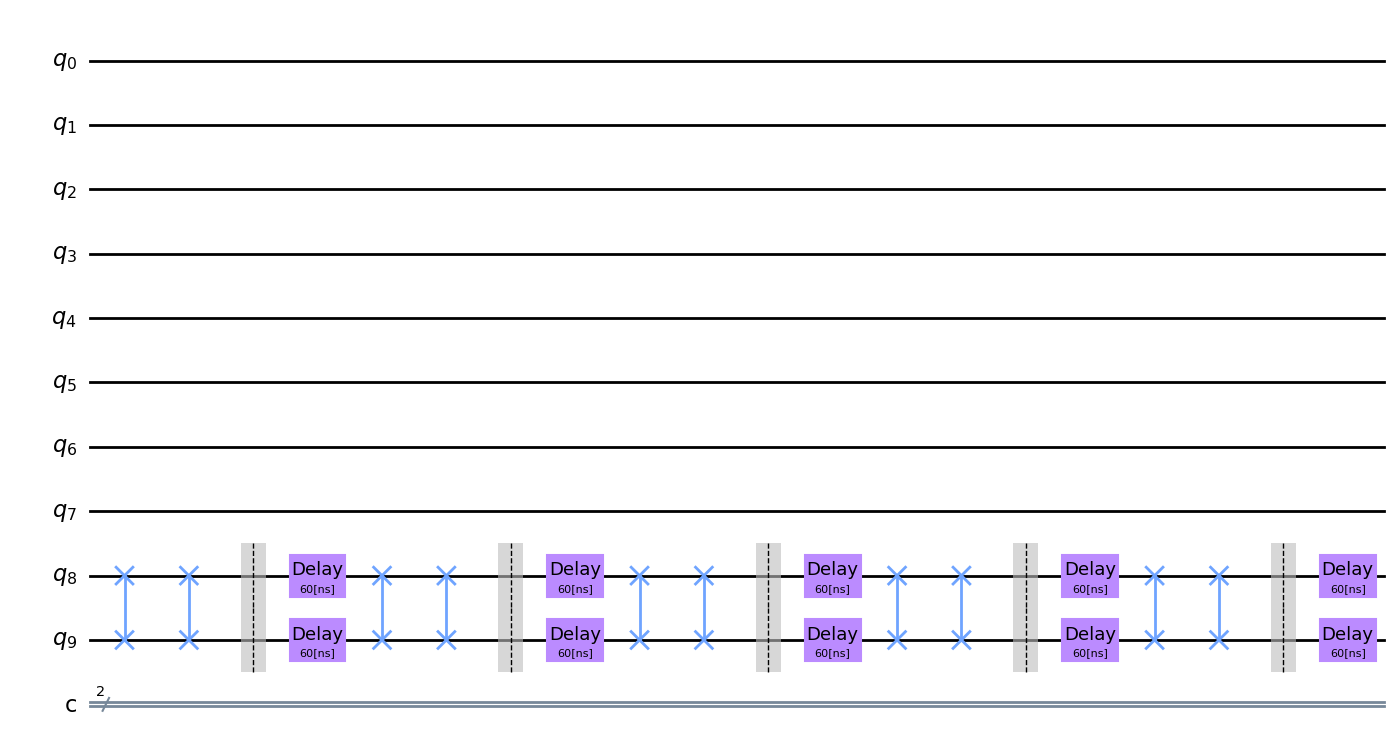

In [66]:
swap_No_HI(5).draw('mpl')

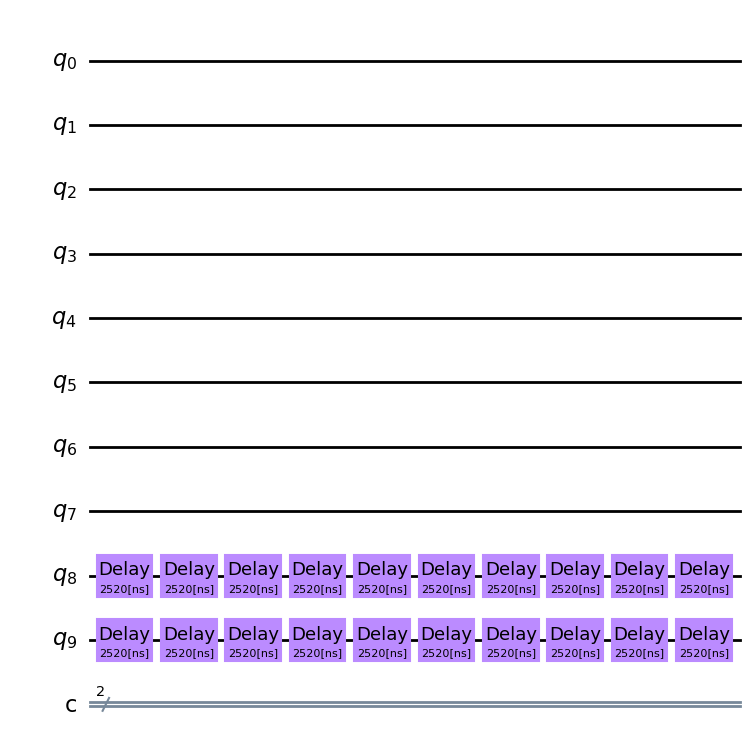

In [87]:
ramsey_2(5).draw('mpl')

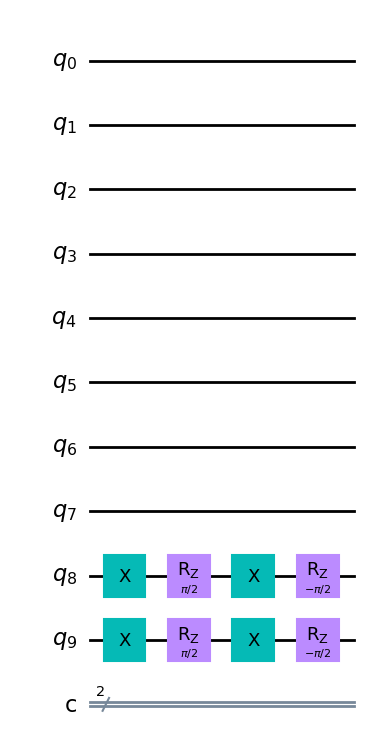

In [95]:
xy4_2(1).draw('mpl')

# Verifying Timing of Circuits for 2 qubits (no initialization)

In [61]:
backend_config = backend.configuration()
dt_value = backend_config.dt
print("dt value:", dt_value)
print("For Osaka backend, 1 nanosecond is 2 dt")

dt value: 5e-10
For Osaka backend, 1 nanosecond is 2 dt


# Swap_HI Timing

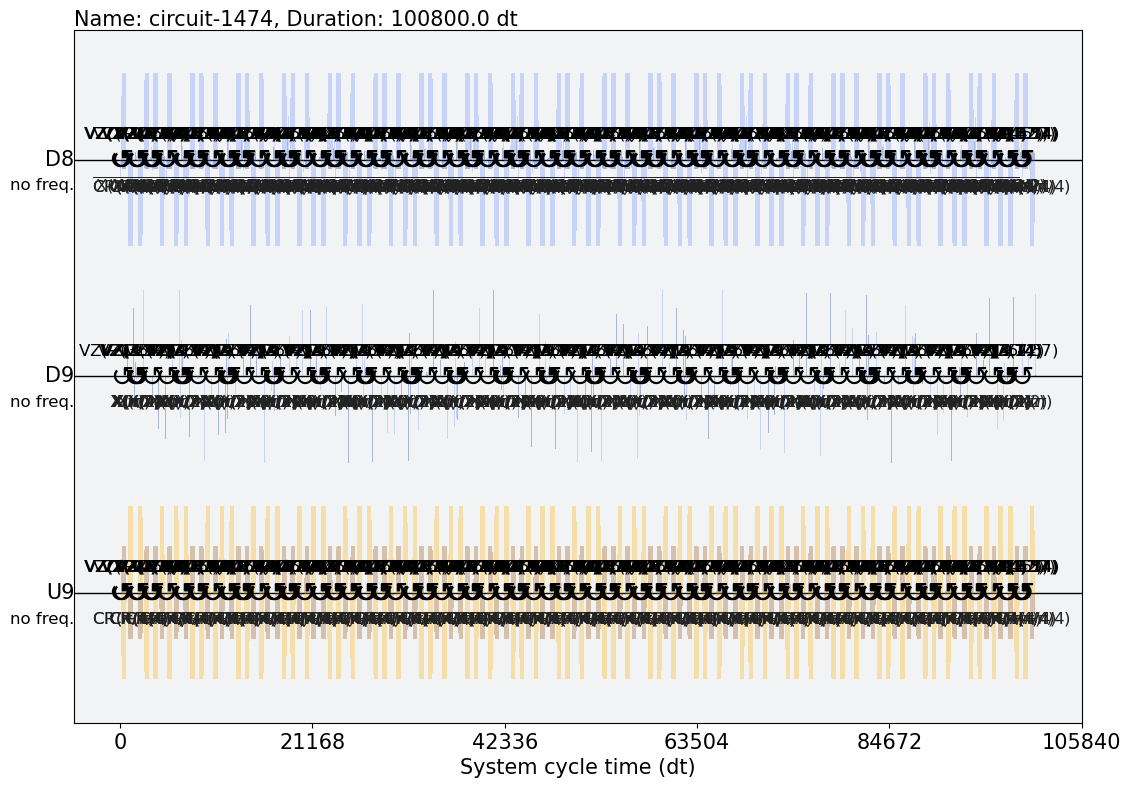

In [101]:
transpiled_Swap_HI = transpile(swap_HI(10), backend=backend, optimization_level = 0)
transpiled_Swap_HI_sched = build_schedule(transpiled_Swap_HI, backend=backend)
transpiled_Swap_HI_sched.draw()

# Swap_No_HI Timing

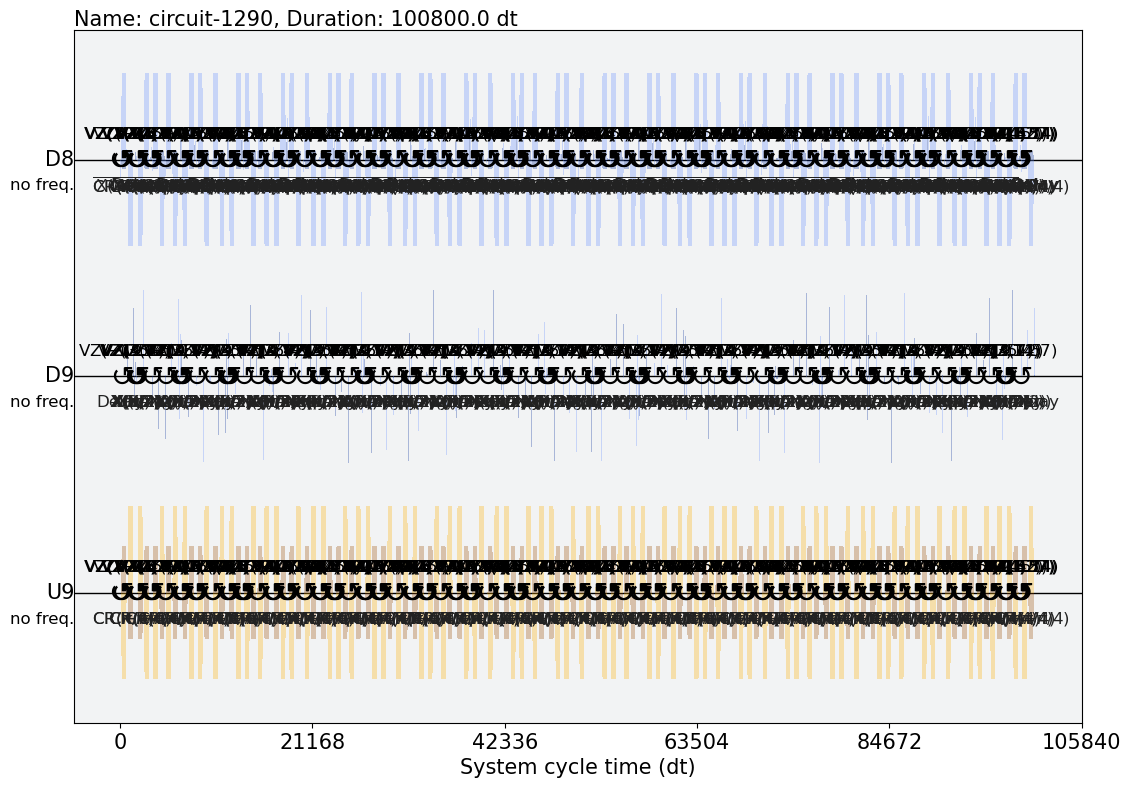

In [68]:
transpiled_Swap_No_HI = transpile(swap_No_HI(10), backend=backend, scheduling_method = 'alap', optimization_level = 0)
transpiled_Swap_No_HI_sched = build_schedule(transpiled_Swap_No_HI, backend=backend)
transpiled_Swap_No_HI_sched.draw()

# Free 2 Qubit Timing

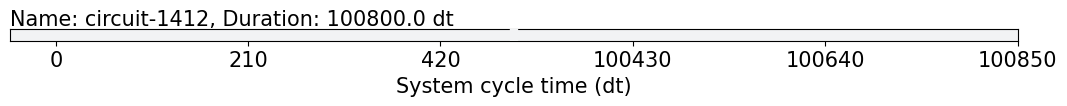

In [88]:
transpiled_free = transpile(ramsey_2(10), backend=backend, scheduling_method = 'alap', optimization_level = 0)
transpiled_free_sched = build_schedule(transpiled_free, backend=backend)
transpiled_free_sched.draw()

# XY4_2 Timing

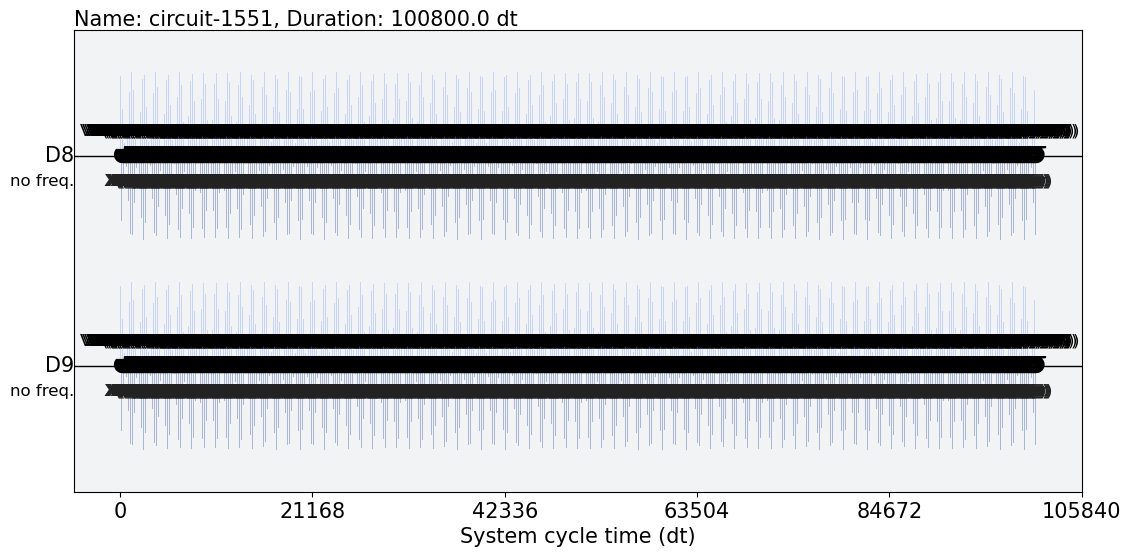

In [106]:
transpiled_xy4_2 = transpile(xy4_2(10), backend=backend, scheduling_method = 'alap', optimization_level = 0)
transpiled_xy4_2_sched = build_schedule(transpiled_xy4_2, backend=backend)
transpiled_xy4_2_sched.draw()

# Verifying Timing of Circuits for 1 and 2 qubits (w / initialization)

# Free 1 Qubit Timing

# XY4 1 Qubit Timing

# Creating Circuit_Builder Function

In [89]:
def circuit_builder(exp, reps):
    if exp == 'free_2':
        circ = ramsey(reps)
    elif exp == 'Swap_No_HI':
        circ = swap_No_HI(reps)
    elif exp == 'Swap_HI':
        circ = swap_HI(reps)
    elif exp == 'free_1':
        circ == ramsey(reps)
    elif exp == 'xy4_1':
        circ == xy4_1(reps):
    elif exp == 'xy4_2':
        circ == xy4_2(reps):
    return circ

# Running Experiments

In [34]:
batch_size = 45
curr_circ_idx = 0
batch_index = 0 # set index for notebook or console when running multiple
starting_circ_idx = batch_index*batch_size
final_circ_idx = starting_circ_idx + batch_size
num_batches = 1

In [ ]:
for curr_circ_idx in range(0, num_batches * batch_size, batch_size):
    
    batch_circuits = experiments[curr_circ_idx: curr_circ_idx + batch_size]
    circuits_to_run = {}
    
    for circ in batch_circuits:
        exp = circ['exp']
        reps = circ['reps']
        circuits_to_run['%s_reps%d' % (exp, reps)] = circuit_builder(exp, reps)
    print('Running circuits...')
    print(len(circuits_to_run))
    print(len(batch_circuits))
    job = qk.execute(list(circuits_to_run.values()), backend=backend, shots = 8000, optimization_level = 0)
    
    #Extract essential information for storage
    job_id = job.job_id()
    circuit_specs = list(circuits_to_run.keys())
    
    circuit_meta_data = {
        'run date': datetime.now().strftime("%Y_%m_%d_%H%M%S"),
        'circuit specs': circuit_specs,
        'job_id': job_id
    }
    filename = '%s-Swap_DD_HI-batch_%s_qubit9_8_2/16.p' % (backend, batch_index)
    print(filename)
    pk.dump(circuit_meta_data, open(filename, 'wb'))
    
    batch_index += 1

# Obtaining Data

In [ ]:
counts_dict = {}

data = []
names = []

circuit_names = []
filename = '%s-Swap_DD_HI-batch_%s_qubit9_8.p' % (backend, 0)
circuit_meta_data = pk.load(open(filename, 'rb'))

 # Extract necessary information from the circuit meta data
circuits_to_run = circuit_meta_data['circuit specs']


#job_id = circuit_meta_data['job_id'] #I GOT THE WRONG JOB ID FOR A DUPLICATE FILENAME
    

# Retrieve the results using the job ID
job = backend.retrieve_job('cqbp9zf3wfsg0083egv0') 
res = job.result().get_counts()
data += res
names += circuit_meta_data['circuit specs']

all_experiment_data = dict(zip(names, data))    
# Save the compiled data for all batches
fname = 'osaka_DD_Swap_HI_dict.p'   
pk.dump(counts_dict, open(fname, 'wb'))   

# Plotting Data

In [ ]:
free_state_avg = []
swap_HI_avg = []
swap_No_HI_avg = []

for i in range(0,15):
    free_state_values = []
    swap_HI_state_values = []
    swap_No_HI_state_values = []
    
    for key, value in all_experiment_data.items():
        if key.startswith(f'free_reps{i}'):
            free_state_values.append(float(value['00']))
        elif key.startswith(f'Swap_No_HI_reps{i}'):
            swap_No_HI_state_values.append(float(value['00']))
        elif key.startswith(f'Swap_HI_reps{i}'):
            swap_HI_state_values.append(float(value['00']))
            
     # Calculate the average fidelity for each state at the current repetition
    free_state_avg.append(sum(free_state_values) / (len(free_state_values)*8000)) 
    swap_HI_avg.append(sum(swap_HI_state_values) / (len(swap_HI_state_values)*8000))
    swap_No_HI_avg.append(sum( swap_No_HI_state_values) / (len(swap_No_HI_state_values)*8000))
    

# Create x-axis values (repetitions)
repetitions = list(range(15))

# Create the plot
plt.plot(repetitions, free_state_avg, label='Free')
plt.plot(repetitions, swap_HI_avg, label='Swap HI')
plt.plot(repetitions, swap_No_HI_avg, label='Swap No HI')


# Set axis labels and plot title
plt.xlabel('Repetitions')
plt.ylabel('Fidelity')
plt.title('Average Fidelity: Free vs. DD with HI vs. DD w/o HI')

# Display legend
plt.legend()

# Show the plot
plt.show()